In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())
      
device = 'cpu'
print(device)

import neuravi

CUDA AVAILABLE?  True
cpu


# Size of dataset analysis

In [2]:
# Data import
prefix= ["0p10val","0p20val","0p30val","0p40val","0p50val","0p60val","0p70val","0p80val"]
suffix = ["_0","_1","_2","_3","_4","_5","_6","_7","_8","_9"]

# variable to record the results
total_size_train = np.zeros(len(prefix))
compo_size_train = np.zeros(len(prefix))
# order for errors is AG, MYEGA, A-M, Raman, Density, Entropy
error_size_train = np.zeros((len(prefix),len(suffix),6))
error_size_valid = np.zeros((len(prefix),len(suffix),6))
error_size_test = np.zeros((len(prefix),len(suffix),6))



# Loss criterion
criterion = torch.nn.MSELoss()

for j in range(len(prefix)): # main loop: between datasets

    # Load the good dataset
    dataset_name = "./data/DataSet_{}.hdf5".format(prefix[j])
    ds = neuravi.data_loader(dataset_name,
                             "./data/NKAS_Raman.hdf5",
                             "./data/NKAS_density.hdf5",
                             "./data/NKAS_optical.hdf5",
                             "./data/NKAS_liquidus.hdf5",
                             device)
    
    # saving in output variables
    total_size_train[j] = len(ds.T_visco_train)
    compo_size_train[j] = np.unique(ds.x_visco_train,axis=0).shape[0]
    
    for i in range(len(suffix)): # subloop: between each different training on one dataset
        
        # Loading the network and freezing dropout
        name_model = "model_l4_n200_p10_data{}{}.pth".format(prefix[j],suffix[i])
        neuralmodel = neuravi.model(4,300,4,ds.nb_channels_raman,p_drop=0.10) 
        neuralmodel.load_state_dict(torch.load("./model/exp_trainsize/"+name_model, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
    
        # train
        y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
        y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
        y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
        y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
        y_density_pred_train = neuralmodel.density(ds.x_density_train)
        y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)

        # valid
        y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
        y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
        y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
        y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
        y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
        y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)

        # test
        y_ag_pred_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)
        y_myega_pred_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)
        y_am_pred_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)
        #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
        y_density_pred_test = neuralmodel.density(ds.x_density_test)
        y_entro_pred_test = neuralmodel.sctg(ds.x_entro_test)

        # Compute Loss

        # train 
        error_size_train[j,i,0] = criterion(y_ag_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,1]  = criterion(y_myega_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,2]  = criterion(y_am_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,3]  = criterion(y_raman_pred_train,ds.y_raman_train).item()
        error_size_train[j,i,4]  = criterion(y_density_pred_train,ds.y_density_train).item()
        error_size_train[j,i,5]  = criterion(y_entro_pred_train,ds.y_entro_train).item()

        # validation
        error_size_valid[j,i,0] = criterion(y_ag_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,1] = criterion(y_myega_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,2] = criterion(y_am_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,3] = criterion(y_raman_pred_valid,ds.y_raman_valid).item()
        error_size_valid[j,i,4] = criterion(y_density_pred_valid,ds.y_density_valid).item()
        error_size_valid[j,i,5] = criterion(y_entro_pred_valid,ds.y_entro_valid).item()

        # test
        error_size_test[j,i,0] = criterion(y_ag_pred_test, ds.y_visco_test).item()
        error_size_test[j,i,1] = criterion(y_myega_pred_test, ds.y_visco_test).item()
        error_size_test[j,i,2] = criterion(y_am_pred_test, ds.y_visco_test).item()
        #"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item()
        error_size_test[j,i,4] = criterion(y_density_pred_test,ds.y_density_test).item()
        error_size_test[j,i,5] = criterion(y_entro_pred_test,ds.y_entro_test).item()

# Architecture results

In [3]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["name"] = list_models

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)
record_loss["loss_ag_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)
record_loss["loss_Sconf_test"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)
record_loss["loss_d_test"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

record_loss["loss_valid"] = np.zeros(nb_exp)
record_loss["loss_test"] = np.zeros(nb_exp)

### Load dataset

path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"
path_liquidus = "./data/NKAS_liquidus.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,path_liquidus,device)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    
    # train
    y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
    y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
    y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
    y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
    y_density_pred_train = neuralmodel.density(ds.x_density_train)
    y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
    y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

    # valid
    y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
    y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
    y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
    y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
    y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
    y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
    y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)
    
    # test
    y_ag_pred_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)
    y_myega_pred_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)
    y_am_pred_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)
    #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
    y_density_pred_test = neuralmodel.density(ds.x_density_test)
    y_entro_pred_test = neuralmodel.sctg(ds.x_entro_test)
    y_ri_pred_test = neuralmodel.sellmeier(ds.x_ri_test, ds.lbd_ri_test)

    # Compute Loss

    # train 
    record_loss.loc[idx,"loss_ag_train"] = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_myega_train"]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_am_train"]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
    record_loss.loc[idx,"loss_raman_train"]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
    record_loss.loc[idx,"loss_d_train"]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
    record_loss.loc[idx,"loss_Sconf_train"]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())
    record_loss.loc[idx,"loss_ri_train"]  = np.sqrt(criterion(y_ri_pred_train,ds.y_ri_train).item())

    # validation
    record_loss.loc[idx,"loss_ag_valid"] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_myega_valid"] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_am_valid"] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
    record_loss.loc[idx,"loss_raman_valid"] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
    record_loss.loc[idx,"loss_d_valid"] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
    record_loss.loc[idx,"loss_Sconf_valid"] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())
    record_loss.loc[idx,"loss_ri_valid"]  = np.sqrt(criterion(y_ri_pred_valid,ds.y_ri_valid).item())
    
    # test
    record_loss.loc[idx,"loss_ag_test"] = np.sqrt(criterion(y_ag_pred_test, ds.y_visco_test).item())
    record_loss.loc[idx,"loss_myega_test"] = np.sqrt(criterion(y_myega_pred_test, ds.y_visco_test).item())
    record_loss.loc[idx,"loss_am_test"] = np.sqrt(criterion(y_am_pred_test, ds.y_visco_test).item())
    #record_loss.loc[idx,"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item())
    record_loss.loc[idx,"loss_d_test"] = np.sqrt(criterion(y_density_pred_test,ds.y_density_test).item())
    record_loss.loc[idx,"loss_Sconf_test"] = np.sqrt(criterion(y_entro_pred_test,ds.y_entro_test).item())
    record_loss.loc[idx,"loss_ri_test"]  = np.sqrt(criterion(y_ri_pred_test,ds.y_ri_test).item())
    
    record_loss.loc[idx,"loss_valid"] = record_loss.loc[idx,"loss_ag_valid"] + record_loss.loc[idx,"loss_raman_valid"] + record_loss.loc[idx,"loss_d_valid"] + record_loss.loc[idx,"loss_Sconf_valid"] + record_loss.loc[idx,"loss_ri_valid"]
    #record_loss.loc[idx,"loss_test"] = record_loss.loc[idx,"loss_ag_test"] + record_loss.loc[idx,"loss_raman_test"] + record_loss.loc[idx,"loss_d_test"] + record_loss.loc[idx,"loss_Sconf_test"] + record_loss.loc[idx,"loss_ri_test"]


# Figure 3 architecture

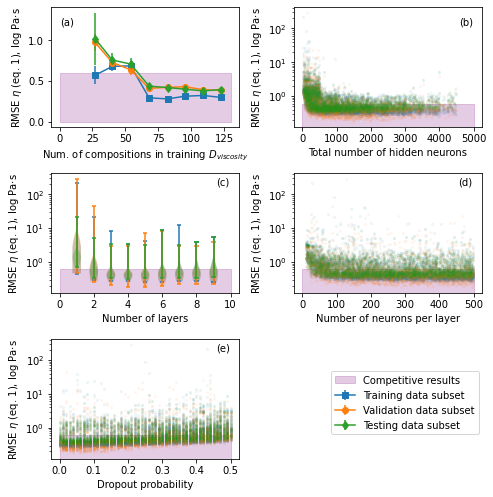

In [7]:
plt.figure(figsize=(7,7))

ax = plt.subplot(3,2,1)
plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_train[:,:,0],axis=1)),
             yerr=np.std(error_size_valid[:,:,0],axis=1),
             marker = "s",color="C0",label="Training data subset"
            )
plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_valid[:,:,0],axis=1)),
             yerr=np.std(error_size_valid[:,:,0],axis=1),
             marker = "o",color="C1",label="Validation data subset"
            )
plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_test[:,:,0],axis=1)),
             yerr=np.std(error_size_test[:,:,0],axis=1),
             marker = "d",color="C2",label="Testing data subset"
            )

plt.fill_between([0,130.],[0,0.],[0.6,0.6],alpha=0.2,color="purple",label="Competitive results")

#plt.xlim(10,120)


plt.annotate("(a)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")
plt.xlabel("Num. of compositions in training $D_{viscosity}$")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")

plt.subplot(3,2,2)
plt.fill_between([0,5000],[0,0.],[0.6,0.6],alpha=0.2,color="purple")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_train"],
         "s",alpha=0.05,ms=2,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_valid"],
         "o",alpha=0.05,ms=2,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_test"],
         "d",alpha=0.05,ms=2,color="C2")
plt.yscale('log')

#plt.ylim(0.01,10000)

plt.xlabel("Total number of hidden neurons")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")
plt.annotate("(b)",xy=(0.95,0.85),xycoords="axes fraction",ha="right")
plt.tight_layout()

plt.subplot(3,2,3)
plt.fill_between([0,10],[0,0.],[0.6,0.6],alpha=0.2,color="purple")
plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_train"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_valid"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_ag_test"].values for i in range(1,10)],
               [i for i in range(1,10)])

plt.yscale('log')
#plt.ylim(0.01,10000)

plt.xlabel("Number of layers")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")
plt.annotate("(c)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,2,4)
plt.fill_between([0,500],[0,0.],[0.6,0.6],alpha=0.2,color="purple")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.05,markersize=2,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.05,markersize=2,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.05,markersize=2,color="C2")
plt.yscale('log')

#plt.ylim(0.01,10000)

plt.xlabel("Number of neurons per layer")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")
           
plt.annotate("(d)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,2,5)
plt.fill_between([0,0.5],[0,0.],[0.6,0.6],alpha=0.2,color="purple")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_train"],"s",color="C0",alpha=0.05,markersize=2,label="Training subset")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_valid"],"o",color="C1",alpha=0.05,markersize=2,label="Validation subset")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_test"],"d",color="C2",alpha=0.05,markersize=2,label="Testing subset")
plt.yscale('log')


#plt.ylim(0.01,10000)

plt.annotate("(e)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.xlabel("Dropout probability")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")

plt.tight_layout()
ax.legend(fancybox=True,bbox_to_anchor=(2.3, -2.))

plt.savefig("./figures/Figure3_architecture.pdf")

# Detect and save best models

For that we use the global "loss_valid" = loss_viscosity + loss_raman + loss_density + loss_refractiveindex

In [8]:
best_recorded = record_loss[(record_loss.nb_layers>2)&(record_loss.nb_layers<6)].nsmallest(10,"loss_valid")
best_recorded

,name,nb_layers,nb_neurons,p_drop,loss_ag_train,loss_ag_valid,loss_ag_test,loss_am_train,loss_am_valid,loss_am_test,...,loss_raman_train,loss_raman_valid,loss_valid,loss_test,loss_myega_train,loss_ri_train,loss_myega_valid,loss_ri_valid,loss_myega_test,loss_ri_test
1643,l4_n208_p0.1.pth,4.0,208.0,0.10,0.341494,0.222652,0.352345,0.374358,0.251263,0.379938,...,0.065891,0.071357,1.238911,0.0,0.402082,0.003248,0.273106,0.003390,0.397600,0.004653
783,l4_n156_p0.1.pth,4.0,156.0,0.10,0.381892,0.237449,0.388837,0.387436,0.253273,0.388852,...,0.077397,0.082593,1.247518,0.0,0.434946,0.003368,0.297618,0.003060,0.407014,0.005117
3115,l5_n73_p0.02.pth,5.0,73.0,0.02,0.382920,0.231616,0.391818,0.372020,0.232128,0.375520,...,0.077825,0.081446,1.262602,0.0,0.423062,0.003403,0.274740,0.003953,0.412576,0.003975
4189,l3_n294_p0.14.pth,3.0,294.0,0.14,0.381985,0.253126,0.348368,0.403078,0.287923,0.346206,...,0.061900,0.065901,1.275465,0.0,0.438700,0.003315,0.329503,0.003029,0.376665,0.004648
2208,l4_n146_p0.08.pth,4.0,146.0,0.08,0.390422,0.207532,0.380994,0.413360,0.224282,0.385519,...,0.073946,0.080130,1.295655,0.0,0.435741,0.004385,0.258423,0.003422,0.394382,0.007115
3534,l5_n316_p0.01.pth,5.0,316.0,0.01,0.347259,0.225551,0.358690,0.367807,0.240355,0.341214,...,0.076761,0.082026,1.301170,0.0,0.364690,0.003171,0.254320,0.003218,0.357317,0.004417
2814,l3_n361_p0.01.pth,3.0,361.0,0.01,0.321966,0.226962,0.382961,0.330187,0.239240,0.390646,...,0.062548,0.072341,1.305767,0.0,0.355672,0.003265,0.246864,0.002850,0.397715,0.004645
120,l5_n311_p0.0.pth,5.0,311.0,0.00,0.318943,0.373306,0.465363,0.298584,0.379627,0.437593,...,0.073212,0.078362,1.311483,0.0,0.298504,0.003000,0.371241,0.002820,0.442841,0.004031
1871,l5_n172_p0.04.pth,5.0,172.0,0.04,0.347321,0.244651,0.350354,0.389071,0.271808,0.369755,...,0.075017,0.082467,1.318198,0.0,0.390789,0.003356,0.281275,0.003656,0.378665,0.004419
2072,l5_n274_p0.04.pth,5.0,274.0,0.04,0.379074,0.198832,0.348211,0.410723,0.233027,0.363114,...,0.066945,0.074423,1.319279,0.0,0.431614,0.003300,0.252096,0.003121,0.369533,0.005458


In [8]:
# importing shutil module  
import shutil 

# Copy the content of 
# source to destination 
for i in best_recorded.loc[:,"name"]:
    shutil.copyfile("./model/exp_arch/"+i, "./model/best/"+i) 

best_recorded.to_csv("./model/best/best_list.csv")